<h1>Advanced lane detection exploration steps:</h1>

* Obtain correction matrix for lense distortion

* Convert images to HLS format and extract S channel data

* Get bird eye view of lanes

* Apply sobel filters to get edge detection

* Apply thresholds in differential output - i.e. threshold against magnitude and direction

* Use histogram data to detect left and right lanes and draw 2nd order polynomial line

* Find centrepoint of polynomial line

* Augment data with line data

In [3]:
#STEP 1: Obtain correction matrix for lense detection, 
# Code taken from https://github.com/udacity/CarND-Advanced-Lane-Lines/examples
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from IPython.display import Image
from IPython.display import display
import math
import glob
import pickle

%matplotlib inline

def corner_details():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    gray = ''
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open( "camera_calibration_result.p", "wb" ))        

def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    return undist

In [4]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

In [ ]:
#Undistort test image
# Test undistortion on an image
#img = cv2.imread('camera_cal/calibration3.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dst = cal_undistort(img, mtx, dist)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp_birds_eye_view(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cal_undistort(img, mtx, dist)
    # Convert undistorted image to grayscale
    gray = img
    if len(np.asarray(img))==2:
        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    img_size = gray.shape

    src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

    dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    # Return the resulting image
    return warped

In [6]:
#Image filters
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    #Convert to grayscale if given gray scale image
    gray = img
    if len(img.shape) ==3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #plt.imshow(gray)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
       
    abs_sobel = np.absolute(abs_sobel)
    abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(abs_sobel)
    # Inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(abs_sobel >= thresh[0]) & (abs_sobel <=thresh[1])] = 1
    
    #plt.imshow(scaled_sobel, cmap ='gray')
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/4)):
    # Grayscale
    #Convert to grayscale if given gray scale image
    gray = img
    if len(img.shape) ==3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    #plt.imshow(binary_output, cmap ='gray')
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(10, 255)): 
    # Convert to grayscale
    #Convert to grayscale if given gray scale image
    gray = img
    if len(img.shape) ==3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    gradmag = np.uint8(gradmag*255/np.max(gradmag))
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #Rescale to 8 bit
    scale_factor = np.max(binary_output)/255
    gradmag = (binary_output/scale_factor).astype(np.uint8) 
    #plt.imshow(gradmag, cmap ='gray')
    return gradmag

def combined_filters(image, ksize = 3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(50, 200))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(50, 200))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20,150))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(.6,1.1))
    combined = np.zeros_like(dir_binary)
    #Find absolute value
    combined[((gradx != 0) & (grady != 0)) | ((mag_binary != 0) & (dir_binary != 0))] = 1
    return combined

def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

In [ ]:
#Test Sobel filters and color filters
#test_img = cv2.imread('test_images/test5.jpg')
img2 =  combined_filters(test_img)
plt.imshow(img2, cmap ='gray')
#plt.imshow(test_img)

In [ ]:
#Undistort and view image
#image = cv2.imread('test_images/test5.jpg')
#image_ud = cal_undistort(image, mtx, dist)
plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off');
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2),cmap='gray')
plt.title('original - undistorted')
plt.axis('off');

In [ ]:
#Undistort and view image
#image = cv2.imread('test_images/straight_lines2.jpg')
image_ud = cal_undistort(image, mtx, dist)
birds_eye_view = corners_unwarp_birds_eye_view(image, mtx, dist)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(birds_eye_view)
plt.title('original')
plt.axis('off')
plt.title('Bird-eye view')
plt.axis('off')

In [7]:
#Color mask filters
def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

In [ ]:
#get birdes eye image
birds_eye_view = corners_unwarp_birds_eye_view(image, mtx, dist)

#Apply color filters
image_hsv=  image_HSV = cv2.cvtColor(birds_eye_view,cv2.COLOR_RGB2HSV)
image_hsv = gaussian_blur(image_hsv, kernel=5)
#White filters
white_hsv_low  = np.array([ 0,   0,   160])
white_hsv_high = np.array([ 255,  80, 255])

#Yellow filters
yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])
#Combined color masks
mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask: yellow and white lanes')
plt.axis('off');

In [ ]:
#Apply sobel filters on L and S channels
image_HLS = cv2.cvtColor(birds_eye_view,cv2.COLOR_RGB2HLS)

#Sobel on L
img_l = image_HLS[:,:,1]
img_abs_x = abs_sobel_thresh(img_l,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_l,'y',5,(50,225))
sobel_l = cv2.bitwise_or(img_abs_x,img_abs_y)

#Sobel on S
img_l = image_HLS[:,:,2]
img_abs_x = abs_sobel_thresh(img_l,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_l,'y',5,(50,225))
sobel_s = cv2.bitwise_or(img_abs_x,img_abs_y)

#Combined L and S channels
image_cmb = cv2.bitwise_or(sobel_s,sobel_l)

#plt.imshow(image)
#image = cv2.imread('test_images/test5.jpg')
sob_c = combined_filters(image)

#Apply image undistortion and perspective transform
bird = corners_unwarp_birds_eye_view(sob_c, mtx, dist)

#Gaussian blur
g_bird = gaussian_blur(bird, kernel=5)

#Combine with color filters
binary_warped = np.zeros_like(image_cmb)
binary_warped[(mask_lane>=.5)|(image_cmb>=.5)]=1

"""plt.subplot(1,3,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter:L and S channels')
plt.subplot(1,3,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('Color-mask')
plt.subplot(1,3,3)
plt.imshow(image_cmb1,cmap='gray')
plt.axis('off')"""
plt.title('Sobel filter and color filter on RGB image')
plt.imshow(binary_warped, cmap='gray')

In [8]:
#image_cmb1 = gaussian_blur(image_cmb1,5) 
def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
"""img_size = bird.shape
mov_filtsize = img_size[1]/50.
mean_lane = np.mean(bird[img_size[0]/2:,:],axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)


plt.subplot(2,1,1)
plt.imshow(bird[img_size[0]/2:,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])"""

"img_size = bird.shape\nmov_filtsize = img_size[1]/50.\nmean_lane = np.mean(bird[img_size[0]/2:,:],axis=0)\nmean_lane = moving_average(mean_lane,mov_filtsize)\n\n\nplt.subplot(2,1,1)\nplt.imshow(bird[img_size[0]/2:,:],cmap='gray')\nplt.axis('off')\nplt.subplot(2,1,2)\nplt.plot(mean_lane>.05)\nplt.plot(mean_lane)\nplt.xlabel('image x')\nplt.ylabel('mean intensity')\nplt.xlim(0,img_size[1])"

In [ ]:
#Boiler plate code from Udacity
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [ ]:
#Boiler plate code from Udacity

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Udacity boiler plate codes
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
#Boiler plate code from Udacity

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
#Recast image onto image
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([leftx, lefty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, righty])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

col_L = (255,255,0)
col_R = (255,255,255)    

def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

def warp_image(img,src,dst,img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped,M,Minv  

src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

draw_pw_lines(color_warp,np.int_(pts_left),col_L)

draw_pw_lines(color_warp,np.int_(pts_right),col_R)

warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))

newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 

result = cv2.addWeighted(image_ud, 1, newwarp, 0.5, 0)

result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(100, 50))
"""plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')
plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on original image')
plt.axis('off')"""
plt.imshow(result)

In [58]:
#Polynomial calculationss
def get_curvature(polynom,y_pt):
    # Returns curvature of a quadratic
    A = polynom[0]
    B = polynom[1]
    return (1+(2*A*y_pt+B)**2)**1.5/2/A

def get_val(y,polnom):
    # Returns value of a quadratic polynomial 
    return polnom[0]*y**2+polnom[1]*y+polnom[2]

In [69]:
#Video pipeline
def video_pipeline(image):
    #Load lense distortion parameters
    with open("camera_calibration_result.p", mode='rb') as f:
        camera_calib = pickle.load(f)
    
    mtx = camera_calib["mtx"]
    dist = camera_calib["dist"]

    #Step 1: Get camera lense and undistort Get birds eye perspective
    unwarped = corners_unwarp_birds_eye_view(image, mtx, dist)

    #Step 2: Apply color and sobel filters
    #####################################
    #Apply color filters
    image_hsv = cv2.cvtColor(unwarped ,cv2.COLOR_RGB2HSV)
    image_hsv = gaussian_blur(image_hsv, kernel=5)
    #White filters
    white_hsv_low  = np.array([ 20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])

    #Yellow filters
    yellow_hsv_low  = np.array([ 0,  100,  100])
    yellow_hsv_high = np.array([ 50, 255, 255])
    #Combined color masks
    mask_yellow = color_mask(image_hsv,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_hsv,white_hsv_low,white_hsv_high)
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white)

    #Apply sobel filters on L and S channels on HLS image
    image_HLS = cv2.cvtColor(unwarped ,cv2.COLOR_RGB2HLS)

    #Sobel on L
    img_l = image_HLS[:,:,1]
    img_abs_x = abs_sobel_thresh(img_l,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_l,'y',5,(50,225))
    sobel_l = cv2.bitwise_or(img_abs_x,img_abs_y)

    #Sobel on S
    img_l = image_HLS[:,:,2]
    img_abs_x = abs_sobel_thresh(img_l,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_l,'y',5,(50,225))
    sobel_s = cv2.bitwise_or(img_abs_x,img_abs_y)

    #Combined L and S channels
    combined_filters = cv2.bitwise_or(sobel_s,sobel_l)
    
    #Combine with color filters
    binary_warped = np.zeros_like(combined_filters)
    binary_warped[(mask_lane>=.5)|(combined_filters>=.5)]=1
    ##########################################
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    ################################################
    #Recast image onto image
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, lefty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, righty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

    col_L = (255,255,0)
    col_R = (255,255,255)    

    def draw_pw_lines(img,pts,color):
        # draw lines
        pts = np.int_(pts)
        for i in range(10):
            x1 = pts[0][i][0]
            y1 = pts[0][i][1]
            x2 = pts[0][i+1][0]
            y2 = pts[0][i+1][1]
            cv2.line(img, (x1, y1), (x2, y2),color,50)

    def warp_image(img,src,dst,img_size):
        # Apply perspective transform
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        Minv = cv2.getPerspectiveTransform(dst, src)
        return warped,M,Minv  

    src = np.float32(
        [[120, 700],
         [550, 470],
         [700, 470],
         [1160, 700]])

    dst = np.float32(
        [[200,700],
         [200,0],
         [1080,0],
         [1080,700]])
    
    img_size = image.shape
    
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)

    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    
    #image = cv2.cvtColor(image ,cv2.COLOR_RGB2HSV)
    
    warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))

    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 

    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)

    #Calculate curvature
    left_curve = get_curvature(left_fit,img_size[0]/2)/1000
    right_curve = get_curvature(right_fit,img_size[0]/2)/1000
    left_curve = math.ceil(left_curve * 100.0) / 100.0
    right_curve =  math.ceil(right_curve * 100.0) / 100.0
    
    #Compute intercepts
    left_bot = get_val(img_size[0],left_fit)
    right_bot = get_val(img_size[0],right_fit)
    
    #Compute center location
    val_center = (left_bot+right_bot)/2.0
    
    #Compute lane offset
    dist_offset = val_center - img_size[1]/2
       
    #Calculate offsets
    #Overlay the image with curvature results
    
    return result

-3.66 -7.34 31.98


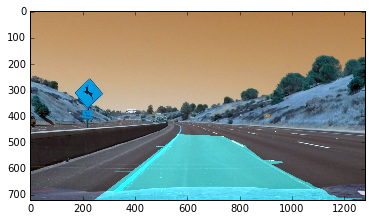

In [70]:
#Undistort and view image
image = cv2.imread('test_images/test2.jpg')
output = video_pipeline(image)
#plt.figure(figsize=(50, 50))
plt.imshow(output)

In [33]:
#Pass through video frames
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'challenge_project_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4");
white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);


[MoviePy] >>>> Building video challenge_project_video.mp4
[MoviePy] Writing video challenge_project_video.mp4


100%|██████████| 485/485 [01:43<00:00,  4.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_project_video.mp4 

CPU times: user 1min 52s, sys: 6.53 s, total: 1min 59s
Wall time: 1min 45s
